# Libraries

In [8]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# modeling libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Classification metric
from sklearn.metrics import classification_report

# Data Preprocessing

In [2]:
df = pd.read_csv("Airline Passenger Satisfaction.csv").set_index('id').drop(columns=['Unnamed: 0', 'satisfaction score'])
df['satisfaction'] = df['satisfaction'].apply(lambda x: 1 if x=='satisfied' else 0)
df = pd.get_dummies(df, columns=['Gender', 'Customer Type', 'Type of Travel', 'Class', ], dtype='int64')

# moving target column to start for easier referrencing
target = 'satisfaction'
column_to_move = df.pop(target)
df.insert(0, target, column_to_move)

In [3]:
df_shuffled = df.sample(frac=1)
train, test, val =  np.split(df_shuffled, [int(len(df_shuffled)*0.6), int(len(df_shuffled)*0.8)])

# Functions

In [4]:
# function for scaling data to be fitted, with additional functionality of oversampling
def scale_data(data, oversample=False):
    x =  data[data.columns[1:]].values
    y = np.reshape(data[data.columns[0]].values, (-1,1))

    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    if oversample:
        ros = RandomOverSampler()
        x, y = ros.fit_resample(x,y)

    data = np.hstack((np.reshape(y, (-1, 1)), x))


    return data, x, y

# function for plotting changes in performance over time
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.legend()
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  ax2.grid(True)

  plt.show()

In [5]:
train, train_x, train_y = scale_data(data=train, oversample = True)
test, test_x, test_y = scale_data(data=test, oversample = False)
val, val_x, val_y = scale_data(data=val, oversample = False)

In [9]:
# building model
nnModel =  Sequential([
    Dense(64, activation = 'relu', input_shape =(train_x.shape[1], )),
    Dropout(0.2),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

nnModel.compile(optimizer=Adam(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

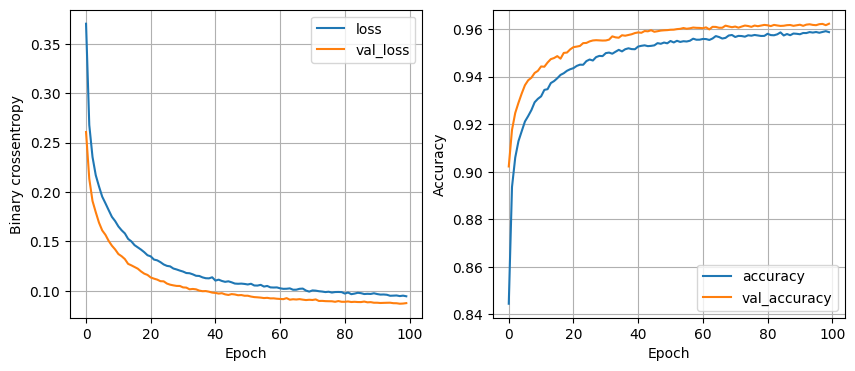

In [10]:
history = nnModel.fit(x=train_x, y=train_y, epochs = 100, batch_size = 32, validation_data = (val_x, val_y), verbose = 0)
plot_history(history)

In [11]:
pred_y = np.reshape(nnModel.predict(test_x), (-1, ))
pred_y = (pred_y >0.5).astype(int)
print(classification_report(test_y, pred_y))

812/812 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     14755
           1       0.97      0.94      0.95     11221

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976



In [12]:
nnModel.save('tf_models/initial_model')

INFO:tensorflow:Assets written to: tf_models/initial_model\assets


INFO:tensorflow:Assets written to: tf_models/initial_model\assets


# Hyperparameter Tuning

## Model function

In [17]:
def build_n_train_model(x_train, y_train, units, dropout, lr, epochs, batchsize):
    nnModel =  Sequential([
        Dense(units, activation = 'relu', input_shape =(x_train.shape[1], )),
        Dropout(dropout),
        Dense(units, activation = 'relu'),
        Dropout(dropout),
        Dense(1, activation = 'sigmoid')
    ])

    nnModel.compile(optimizer=Adam(learning_rate=lr),
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])
    
    history = nnModel.fit(x_train, y_train, validation_split=0.2, epochs = epochs, batch_size = batchsize)

    return nnModel, history

In [21]:
unit_list  = [16, 32, 64]
dropout_list = [0, 0.2]
lr_list = [0.01, 0.005, 0.001]
batchsize_list = [32, 64, 128]

least_val_loss = float('inf')
least_loss_model = None

for unit in unit_list:
    for dropout in dropout_list:
        for lr  in lr_list:
            for batchsize in batchsize_list:
                print(f'{unit} units, {dropout} dropout, {lr} learning rate, {batchsize} batchsize')
                res_model, history = build_n_train_model(x_train=train_x, y_train=train_y,
                                                         units = unit,
                                                         dropout = dropout,
                                                         lr = lr,
                                                         epochs = 100,
                                                         batchsize = batchsize)
                plot_history(history)

                val_loss =  res_model.evaluate(val_x, val_y)[0]
                if val_loss < least_val_loss:
                    least_val_loss=val_loss
                    least_loss_model = res_model

16 units, 0 dropout, 0.01 learning rate, 32 batchsize
Epoch 1/100
2204/2204 [==============================] - 10s 4ms/step - loss: 0.1829 - accuracy: 0.9256 - val_loss: 0.1811 - val_accuracy: 0.9221
Epoch 2/100
1207/2204 [===============>..............] - ETA: 3s - loss: 0.1360 - accuracy: 0.9420

KeyboardInterrupt: 

In [ ]:
pred_y = np.reshape(least_loss_model.predict(test_x), (-1, ))
pred_y = (pred_y >0.5).astype(int)
print(classification_report(test_y, pred_y))

In [ ]:
least_loss_model.save('tf_models/tuned_model')